In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 18 14:40:49 2019

@author: L-F-S
@ University of Trento, Italy
"""

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wdir="/home/lorenzo/cereseto lab/Aiello_EvolvR_Jan2020/"
n='1'#str(input("Quale sample vuoi osservare? [0, 1, 2, 3, A]"))
is_deduped=True
if not is_deduped:
    dataname="/home/lorenzo/Cas_mining/mapping/vcf_pacbam_out/SS"+n+"_CJ_variant.sorted.pileup"
    samplename="S"+n
else:
    dataname="/home/lorenzo/Cas_mining/mapping/vcf_pacbam_out/deduped/SS"+n+"_CJ_variant.sorted.pileup"
    samplename="S"+n+"_dedup"
samplename="L-JON_S2_L001_R1_001_trimmed.fq.gz.sorted.pileup"
dataname="/home/lorenzo/cereseto lab/Aiello_EvolvR_Jan2020/03_variant_calling/"+samplename
original_pileup=pd.read_csv(dataname, sep="\t", header=0)
print(original_pileup.columns) #chr, pos, ref , A, C , G , T, af , cov

Index(['chr', 'pos', 'ref', 'A', 'C', 'G', 'T', 'af', 'cov'], dtype='object')


In [63]:
#we are interested in values relative to coverage:
for letter in ["A", "T","C","G"]:
    original_pileup[letter]=original_pileup[letter]/original_pileup["cov"]
print(original_pileup.tail())

          chr  pos ref         A         C         G         T        af  \
196  Ref_201   197   C  0.000662  0.999289  0.000004  0.000045  0.000711   
197  Ref_201   198   T  0.001487  0.001153  0.000906  0.996454  0.003546   
198  Ref_201   199   A  0.997260  0.001662  0.000922  0.000156  0.002740   
199  Ref_201   200   C  0.000210  0.999735  0.000000  0.000055  0.000265   
200  Ref_201   201   A  0.881446  0.097108  0.020916  0.000530  0.118554   

        cov  
196  951520  
197  953016  
198  951057  
199  950546  
200   20750  


In [64]:
#index is the 1 based position (position 1 is missing for some reason, ma 
# fortunatamente non ci interessa)
pileup=original_pileup

In [67]:
#
# se il primer è gcaagctga
start=10
end=201
#add a label to the old data to indicate if this part belongs to CJ or not
pileup["is_protein"]= [ True if x>=start and x<= end else False for x in pileup["pos"] ]
#pileup["pos"]=pileup["pos"]-start+1
#just slice out if needed:
#CJ_pileup=pileup[pileup["is_protein"]==True]

print(pileup.loc[190:201])
print(pileup.head(11))

          chr  pos ref         A         C         G         T        af  \
190  Ref_201   191   C  0.000150  0.999631  0.000007  0.000212  0.000369   
191  Ref_201   192   G  0.000417  0.000015  0.999505  0.000064  0.000495   
192  Ref_201   193   G  0.000317  0.000013  0.999627  0.000043  0.000373   
193  Ref_201   194   C  0.000120  0.999707  0.000021  0.000152  0.000293   
194  Ref_201   195   A  0.999823  0.000065  0.000073  0.000039  0.000177   
195  Ref_201   196   A  0.999864  0.000061  0.000055  0.000020  0.000136   
196  Ref_201   197   C  0.000662  0.999289  0.000004  0.000045  0.000711   
197  Ref_201   198   T  0.001487  0.001153  0.000906  0.996454  0.003546   
198  Ref_201   199   A  0.997260  0.001662  0.000922  0.000156  0.002740   
199  Ref_201   200   C  0.000210  0.999735  0.000000  0.000055  0.000265   
200  Ref_201   201   A  0.881446  0.097108  0.020916  0.000530  0.118554   

        cov  is_protein  
190  949747        True  
191  957450        True  
192  9554

In [61]:
print(pileup[pileup["pos"]==201])


Empty DataFrame
Columns: [chr, pos, ref, A, C, G, T, af, cov, is_protein]
Index: []


In [68]:
#trucchetto per evidenziare il leibel:
def valore_ref(row): #1 aggiungi una colonna colla frazione della base reference
    letter=row["ref"]
    return row[letter]
def remove_ref(row):  #2 azzera la base reference
    letter=row["ref"]
    row[letter]=0.0
    return row

#CJ_pileup["ref_value"]=CJ_pileup.apply(valore_ref, axis=1)
#CJ_pileup=CJ_pileup.apply(remove_ref, axis=1)

pileup["ref_value"]=pileup.apply(valore_ref, axis=1)
pileup=pileup.apply(remove_ref, axis=1)
pileup.tail()

,chr,pos,ref,A,C,G,T,af,cov,is_protein,ref_value
196,Ref_201,197,C,0.000662,0.000000,0.000004,0.000045,0.000711,951520,True,0.999289
197,Ref_201,198,T,0.001487,0.001153,0.000906,0.000000,0.003546,953016,True,0.996454
198,Ref_201,199,A,0.000000,0.001662,0.000922,0.000156,0.002740,951057,True,0.997260
199,Ref_201,200,C,0.000210,0.000000,0.000000,0.000055,0.000265,950546,True,0.999735
200,Ref_201,201,A,0.000000,0.097108,0.020916,0.000530,0.118554,20750,True,0.881446


In [44]:
#plot senza distanze vere
cutoff=0.1 #allelic fraction cutoff over which to consider a mutation

CJ_sliced=pileup[pileup["af"]>=cutoff][pileup["is_protein"]==True] #bo nn se sa che ho fatto ma tanot nn fa piu il grafico qua

/home/lorenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [46]:
CJ_pileup=pileup[pileup["is_protein"]==True]

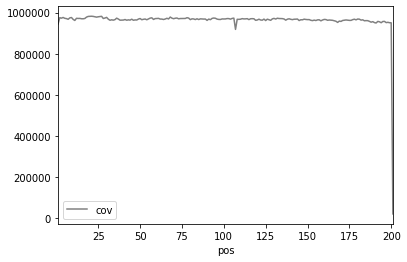

In [69]:
# plot coverage

pileup.plot(x='pos', y='cov',color='gray')
plt.savefig(wdir+"/"+samplename[:5]+"_cov.png")

In [11]:
print("median absolute deviation", pileup["af"].mad())

median absolute deviation 0.001315022350931908


count    201.000000
mean       0.001063
std        0.008345
min        0.000068
25%        0.000199
50%        0.000293
75%        0.000529
max        0.118554
Name: af, dtype: float64
median	 0.000293


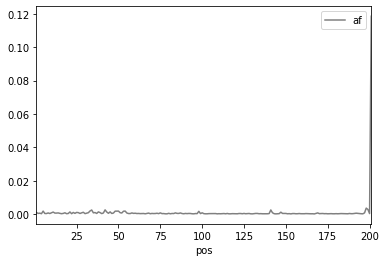

In [20]:
#plot allelic fraction
pileup.plot(x='pos', y='af',color='gray')
print(pileup["af"].describe())
print("median\t", pileup["af"].median())
plt.savefig(wdir+"/"+samplename[:5]+"_af.png")

In [22]:
from plotnine import *

In [23]:
def mycolorpalette(color):
    if color:
        return "cyan"
    return "gray"

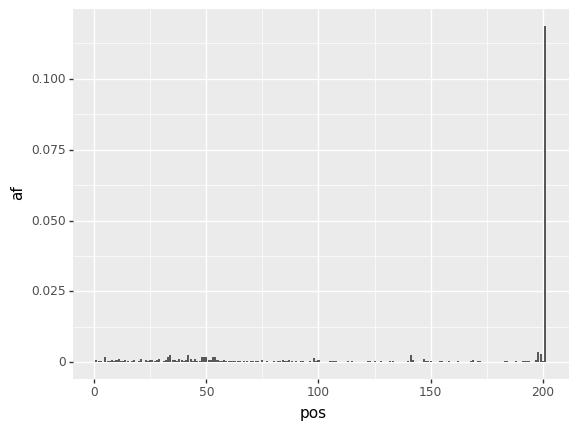

<ggplot: (8775426851094)>


In [70]:
plot=(ggplot(pileup)         # defining what data to use
 + aes(x='pos', y='af') #color="is_protein")      # defining what variable to use
 + geom_col()# defining the type of plot to use
# +scale_color_manual(values={False:"grey", True:"cyan"})
)
print(plot)

In [31]:
ggsave(plot+theme_bw(), filename=wdir+"/"+samplename[:5]+"af_v2.png")


/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/lorenzo/cereseto lab/Aiello_EvolvR_Jan2020//L-JONaf_v2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [76]:
pileup.head()

,chr,pos,ref,A,C,G,T,af,cov,is_protein,ref_value
0,Ref_201,1,G,0.000615,0.000041,0.000000,0.000257,0.000913,944885,False,0.999087
1,Ref_201,2,C,0.000124,0.000000,0.000156,0.000097,0.000377,975518,False,0.999623
2,Ref_201,3,A,0.000000,0.000325,0.000147,0.000039,0.000511,973135,False,0.999489
3,Ref_201,4,A,0.000000,0.000117,0.000055,0.000041,0.000213,976617,False,0.999787
4,Ref_201,5,G,0.000175,0.001275,0.000000,0.000304,0.001754,972392,False,0.998246


In [77]:
# create a dataset with 4 more rows per column, and one more column called 'color_map' (which can be A,C,T,G,ref,plasmid), so every column tells
# what the value is, and the rows A,C,T,G,ref are just 1 row: value

def reshape_dataframe(pileup):
    reshaped_pileup=pd.DataFrame(columns=["pos","ref","value","color_map"])
#    reshaped_ind=0
    for ind, position in pileup.iterrows():
 #       is_protein=position["is_protein"]
        pos=position["pos"]
        ref=position["ref"]
        newrow={"pos":pos,"ref":ref}
   #     print("sono alla posizione: ", pos)
        for cosetta in ["A","T","G","C"]:
   #         print("lettera"+cosetta+"\n")
            temp_value=position[cosetta]
            newrow["value"]=temp_value
            newrow["color_map"]=cosetta
            reshaped_pileup=reshaped_pileup.append(newrow,ignore_index=True)
  #          if not is_protein:
   #             reshaped_pileup.loc[reshaped_ind]["color_map"]="plasmid"
 #           reshaped_ind+=1
  #  reshaped.dropna(how="all", inplace=True) #drop rows completely blank (che ho messo un index troppo lungo)
    reshaped_pileup.fillna(value=0, inplace=True)  #sostituisci nan con 0
    return reshaped_pileup



In [78]:
reshaped_pileup=reshape_dataframe(pileup)

In [79]:
reshaped_pileup.head()

,pos,ref,value,color_map
0,1,G,0.000615,A
1,1,G,0.000257,T
2,1,G,0.000000,G
3,1,G,0.000041,C
4,2,C,0.000124,A


In [80]:
reshaped_pileup_noref=reshaped_pileup[reshaped_pileup["color_map"]!=reshaped_pileup["ref"]]

In [81]:
reshaped_pileup_noref.head()

,pos,ref,value,color_map
0,1,G,0.000615,A
1,1,G,0.000257,T
3,1,G,0.000041,C
4,2,C,0.000124,A
5,2,C,0.000097,T


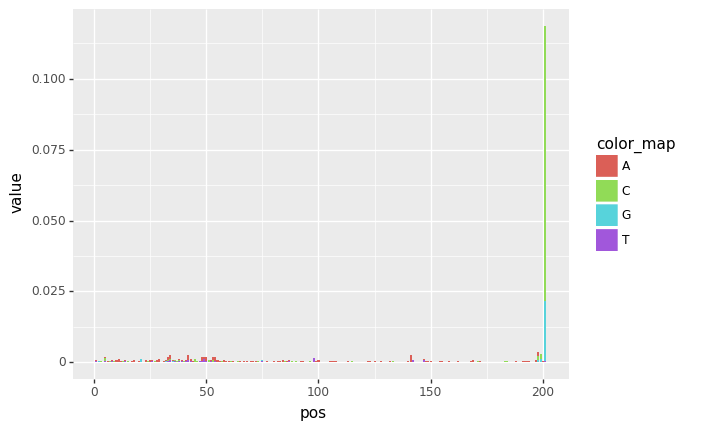

<ggplot: (-9223363261427687992)>


In [71]:
plot=(ggplot(reshaped_pileup_noref)         
 + aes(x='pos', y='value', fill="color_map")      
 + geom_bar(position="stack", stat='identity')
)
print(plot)

In [47]:
ggsave(plot+theme_bw(),filename=wdir+"/"+samplename[:5]+"_pbaf.pdf")

/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/lorenzo/cereseto lab/Aiello_EvolvR_Jan2020//L-JON_pbaf.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


# Da fa domani
modifica queste due funzioncine qui to take into account il reference che abbiamo
magari prima guarda anche visualmente il coverage e le AF dei 4 samples

In [82]:
def call_variant(position, median_af, mad_af):
    #takes as input a dataset with the af of each base, and the reference
    ref=position["ref"]
    k=1.4826
    af_of_variant={}
    for letter in ["A", "C","G","T"]:
        if letter != ref:
            temp_af=position[letter]
            if temp_af > median_af+mad_af*k:
                af_of_variant[letter]=temp_af  
    return af_of_variant

def call_variant_with_cutoff(position, cutoff):
    ref=position["ref"]
    k=1.4826
    af_of_variant={}
    for letter in ["A", "C","G","T"]:
        if letter != ref:
            temp_af=position["af"]
            if temp_af >= cutoff:
                af_of_variant[letter]=position[letter]  
    return af_of_variant

In [90]:
median_af=pileup["af"].median()
mad_af=pileup["af"].mad()
called_variants=pd.DataFrame()
for ind, position in pileup.iterrows():
    pos=int(position["pos"])
    ref=position["ref"]
    new_row={"pos":pos,"ref":ref, "A":None ,"C":None,"T":None,"G":None}
    if position["is_protein"]:
        variants=call_variant(position,median_af,mad_af)
        new_row.update(variants)
        called_variants=called_variants.append(new_row, ignore_index=True)
called_variants.dropna(subset=["A","C","G","T"], how="all", inplace=True)
print(called_variants.head())

              A          C          G     T    pos ref
131  0.00234984       None       None  None  141.0   G
191        None  0.0971084  0.0209157  None  201.0   A


In [91]:
called_variants

,A,C,G,T,pos,ref
131,0.00234984,None,None,None,141.0,G
191,None,0.0971084,0.0209157,None,201.0,A


In [92]:
called_variants.shape

(2, 6)

In [356]:
cutoff_called_variants=pd.DataFrame()
for ind, position in pileup.iterrows():
    pos=int(position["pos"])
    ref=position["ref"]
    new_row={"pos":pos,"ref":ref}
    if position["is_protein"]:
        variants=call_variant_with_cutoff(position,0.1)
        new_row.update(variants)
        cutoff_called_variants=cutoff_called_variants.append(new_row, ignore_index=True)
cutoff_called_variants.dropna(subset=["A","C","G","T"],how="all", inplace=True)
print(cutoff_called_variants.head())

       pos ref      C      G      T      A
359  360.0   A  0.002  0.001  0.104    NaN
701  702.0   G  0.001    NaN  0.099  0.002
721  722.0   T  0.315  0.001    NaN  0.001
750  751.0   G  0.001    NaN  0.003  0.106
803  804.0   T  0.002  0.001    NaN  0.358


In [359]:
print(cutoff_called_variants.shape)

(25, 6)


In [63]:
reshaped=reshape_dataframe(called_variants)
print(reshaped.shape)
print(reshaped.head())


(432, 4)
    pos ref  value color_map
0   5.0   G  0.019         A
1   5.0   G  0.000         T
2   5.0   G  0.000         G
3   5.0   G  0.000         C
4  11.0   C  0.026         A


plotting


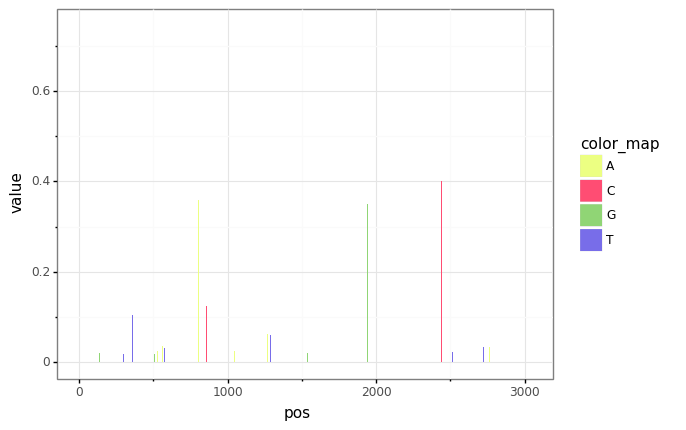

<ggplot: (-9223363305252941806)>


In [67]:

print("plotting")
plot=(ggplot(reshaped)        
 + aes(x='pos', y='value', fill="color_map")      
 +geom_bar(position="stack",stat="identity")
 +scale_fill_manual(values={"T":"#786de9", "A":"#ecff82","C":"#ff4d73", "G":"#90d575"})
 #+scale_x_categorical()
)
print(plot+theme_bw())
#color (in eas è il colore dell'outline), fill il colore dell'interno della barra

In [62]:
#saving
ggsave(plot+coord_cartesian(ylim=[0,0.6])+theme_bw(), filename="imgs/af_after_calling"+samplename+".png", width=60, height=2*6, limitsize=False)


/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 60 x 12 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/lorenzo/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: imgs/af_after_callingS1_dedup.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


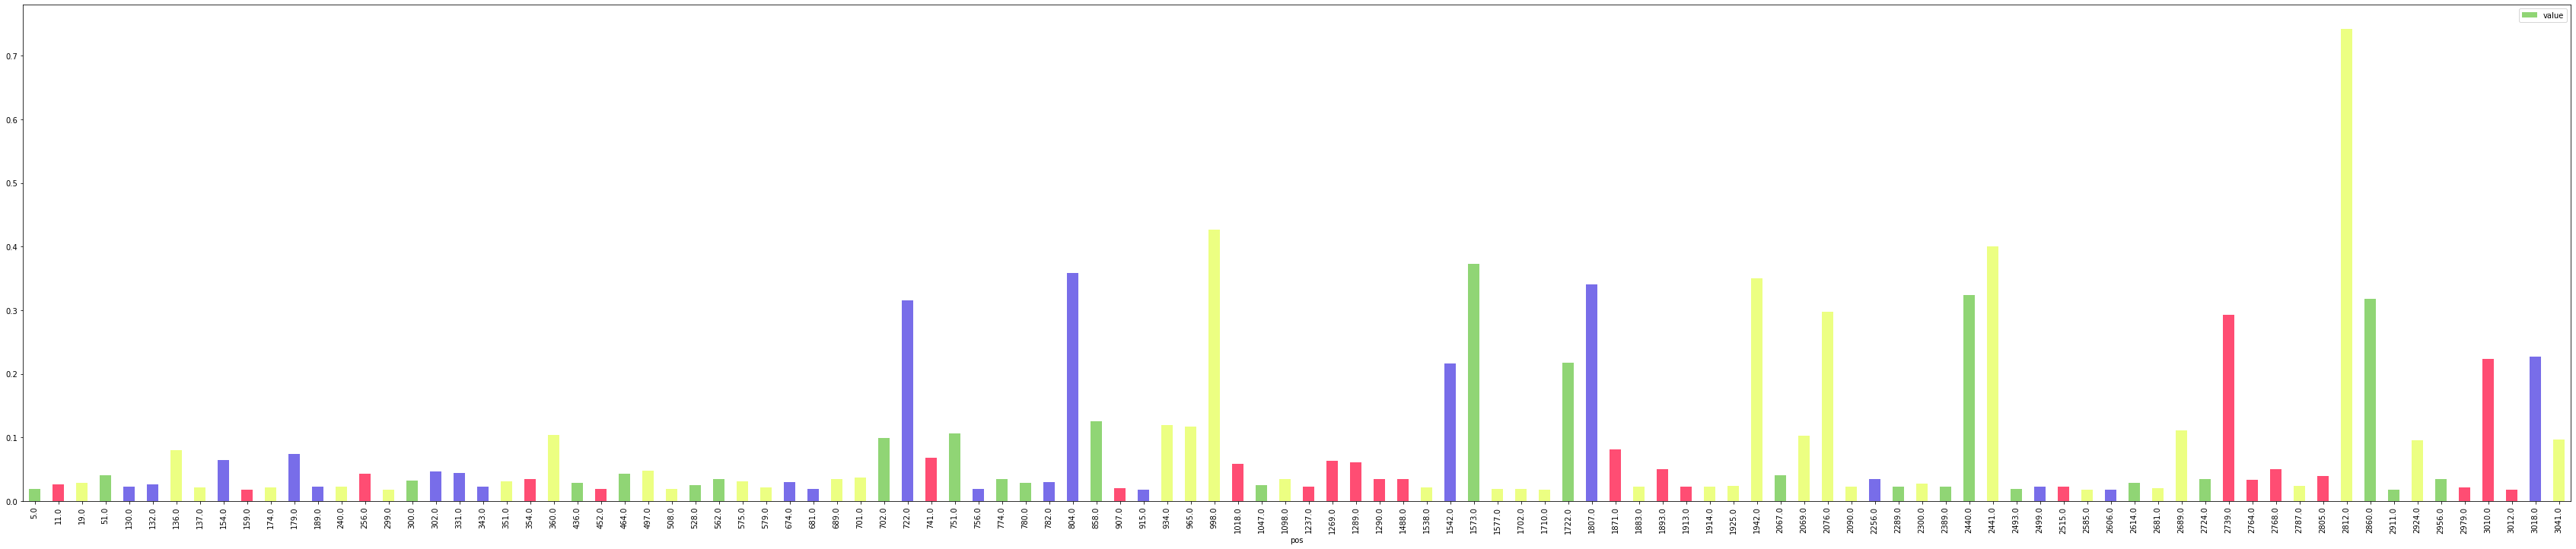

In [95]:
#use matplotlib x plottare solo le variantine

reshaped_formatplotlib=reshaped[reshaped["value"]!=0.000]
color_of={"T":"#786de9", "A":"#ecff82","C":"#ff4d73", "G":"#90d575"}


reshaped_formatplotlib.plot(kind="bar", x="pos", y="value", color=[color_of[ref] for ref in reshaped_formatplotlib["ref"]], figsize=(60,12))
plt.savefig("imgs/prv.png")